In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 

In [26]:
df = pd.read_csv('data/3_clean_zomato_gof_500.csv')
df['rest_price_idr'] = df['rest_price_idr'] / 1000
df['rest_price_idr'] = df['rest_price_idr'].astype(int)
# df['rank_res_type'] = df['rank_res_type'].astype(int)
# df['rank_fac'] = df['rank_fac'].astype(int)

<AxesSubplot:ylabel='Frequency'>

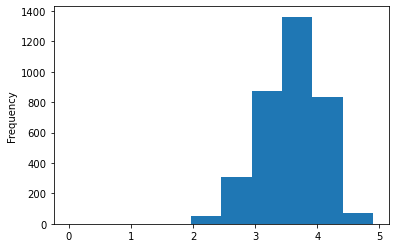

In [28]:
df['rating'].plot(kind='hist')

In [29]:
# df.isnull().sum()

In [30]:
df.head()

,index,url,rest_price_idr,review,lat,long,is_chain,rating,new_code_res_type,rank_res_type,...,d_500_hospital,d_500_lodging,d_500_meal_takeaway,d_500_mosque,d_500_park,d_500_restaurant,d_500_school,d_500_store,d_500_supermarket,d_500_train_station
5693,7139,https://www.zomato.com/jakarta/batako-pondok-i...,120,6.0,-6.282445,106.773646,0,3.3,4,0,...,2.0,3.0,0.0,3.0,0.0,0.0,6.0,3.0,1.0,0.0
4275,5266,https://www.zomato.com/jakarta/bakmi-keriting-...,80,10.0,-6.116933,106.781534,0,3.5,0,244,...,1.0,1.0,0.0,0.0,2.0,6.0,0.0,0.0,1.0,0.0
3534,4326,https://www.zomato.com/jakarta/crunchaus-salad...,130,9.0,-6.207883,106.821072,1,3.9,0,30,...,37.0,9.0,0.0,15.0,2.0,25.0,12.0,7.0,21.0,0.0
1449,1690,https://www.zomato.com/jakarta/malioboro-senop...,100,5.0,-6.236450,106.815197,0,3.4,1,5,...,0.0,10.0,0.0,5.0,6.0,4.0,4.0,0.0,0.0,0.0
4128,5083,https://www.zomato.com/jakarta/marugame-udon-p...,120,206.0,-6.265647,106.782858,1,4.3,2,1,...,0.0,0.0,0.0,3.0,1.0,9.0,2.0,0.0,0.0,0.0


In [31]:
# df.info()

In [32]:
df.isnull().sum()

index                      0
url                        0
rest_price_idr             0
review                     0
lat                        0
long                       0
is_chain                   0
rating                     0
new_code_res_type          0
rank_res_type              0
new_code_fac               0
rank_fac                   0
geohash                    0
d_500_airport              0
d_500_atm                  0
d_500_bank                 0
d_500_cafe                 0
d_500_convenience_store    0
d_500_gas_station          0
d_500_hospital             0
d_500_lodging              0
d_500_meal_takeaway        0
d_500_mosque               0
d_500_park                 0
d_500_restaurant           0
d_500_school               0
d_500_store                0
d_500_supermarket          0
d_500_train_station        0
dtype: int64

In [33]:
# scaler = MinMaxScaler()
# Y = scaler.fit_transform(df[['rating']])
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review','new_code_res_type','new_code_fac'],axis=1), Y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review'],axis=1), Y, test_size=0.3, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash'],axis=1), df['rating'], test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['url','index','rating','lat','long','review'],axis=1), df['rating'], test_size=0.3, random_state=42)

In [34]:
X_train.head()

,rest_price_idr,is_chain,rank_res_type,rank_fac,d_500_airport,d_500_atm,d_500_bank,d_500_cafe,d_500_convenience_store,d_500_gas_station,d_500_hospital,d_500_lodging,d_500_meal_takeaway,d_500_mosque,d_500_park,d_500_restaurant,d_500_school,d_500_store,d_500_supermarket,d_500_train_station
4202,90,1,123,0,0.0,1.0,1.0,4.0,3.0,10.0,4.0,1.0,0.0,1.0,2.0,0.0,2.0,1.0,5.0,0.0
4955,500,0,397,888,0.0,13.0,4.0,3.0,0.0,0.0,1.0,6.0,1.0,4.0,0.0,7.0,2.0,3.0,3.0,0.0
3442,80,0,0,0,0.0,22.0,4.0,6.0,20.0,0.0,2.0,15.0,58.0,13.0,4.0,8.0,5.0,31.0,11.0,0.0
1020,80,0,77,0,0.0,13.0,5.0,7.0,9.0,3.0,5.0,13.0,0.0,5.0,3.0,4.0,1.0,11.0,0.0,0.0
685,60,0,79,10,0.0,10.0,3.0,6.0,3.0,0.0,2.0,12.0,0.0,4.0,0.0,4.0,3.0,10.0,7.0,0.0


In [35]:
X_train.shape

(2800, 20)

In [36]:
regr = RandomForestRegressor(random_state=0,n_estimators=30, max_depth = 10)
# regr = RandomForestClassifier()
regr.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=30, random_state=0)

In [37]:
y_result_test = regr.predict(X_test)
y_result_train = regr.predict(X_train)
print(' MAE {} '.format(mean_absolute_error(y_result_test,y_test)))
print(' MSE {} '.format(mean_squared_error(y_result_test,y_test)))
print(' R2 {} '.format(r2_score(y_train,y_result_train)))

 MAE 0.36958996857965976 
 MSE 0.22790528849477015 
 R2 0.5583527544868079 


In [38]:
# result_train = pd.DataFrame()
# result_train['score'] = y_result_train
# result_train['type'] = 'train'
# result_train['idx'] = result_train.shape[0]

result_test = pd.DataFrame()
result_test['score'] = y_result_test
result_test['type'] = 'test'
result_test['idx'] = np.arange(result_test.shape[0])

result_test2 = pd.DataFrame()
result_test2['score'] = np.squeeze(y_test)
# result_test2['score'] = y_test
result_test2['type'] = 'train'
result_test2['idx'] = np.arange(result_test2.shape[0])



df_result = pd.concat([result_test2,result_test])
# result = pd.DataFrame({'predict':y_result_test,'real':y_test})
# result['predict'] = y_result_test
# result['real'] = y_test

In [39]:
df_result

,score,type,idx
4676,3.700000,train,0
4262,3.100000,train,1
3693,2.300000,train,2
4496,3.200000,train,3
3336,3.600000,train,4
...,...,...,...
695,3.503028,test,695
696,3.715372,test,696
697,3.630934,test,697
698,4.015317,test,698


<AxesSubplot:xlabel='idx', ylabel='score'>

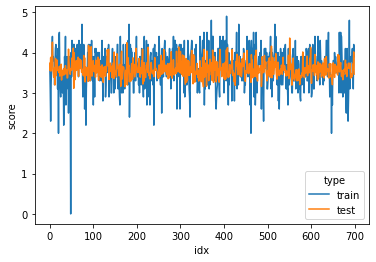

In [40]:
sns.lineplot(data=df_result, x="idx", y='score', hue="type")

In [41]:
# feature importance 
df_feat = pd.DataFrame({'score':regr.feature_importances_,'columns':X_train.columns})
df_feat.sort_values('score',ascending=False)


,score,columns
0,0.243920,rest_price_idr
3,0.113751,rank_fac
2,0.089292,rank_res_type
15,0.056233,d_500_restaurant
5,0.052178,d_500_atm
16,0.048438,d_500_school
6,0.046332,d_500_bank
13,0.041981,d_500_mosque
7,0.040251,d_500_cafe
8,0.038739,d_500_convenience_store
